In [40]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import sys

In [1]:

#sys.path.append('../../')
from xcontour import Contour2D, latitude_lengths_at, add_latlon_metrics

dset = xr.open_dataset('PV.nc')

print(dset)

# add metrics for xgcm.Grid
dset, grid = add_latlon_metrics(dset)

# get PV as a tracer and its squared gradient
tracer = dset.pv
grdS = dset.grdSpv

<xarray.Dataset>
Dimensions:    (latitude: 241, level: 15, longitude: 480)
Coordinates:
  * longitude  (longitude) float32 0.0 0.75 1.5 2.25 ... 357.0 357.8 358.5 359.2
  * latitude   (latitude) float32 -90.0 -89.25 -88.5 -87.75 ... 88.5 89.25 90.0
  * level      (level) int32 265 275 285 300 315 330 ... 430 475 530 600 700 850
    time       datetime64[ns] ...
Data variables:
    pv         (level, latitude, longitude) float32 ...
    grdSpv     (level, latitude, longitude) float32 ...
Attributes:
    units:      K m**2 kg**-1 s**-1
    long_name:  Potential vorticity


# xcontour

In [45]:
N  = 121           # increase the contour number may get non-monotonic A(q) relation
increase = True    # Y-index increases with latitude (sometimes not)
lt = False          # northward of PV contours (larger than) is inside the contour
                   # change this should not change the result of Keff, but may alter
                   # the values at boundaries
dtype = np.float32 # use float32 to save memory
undef = -9.99e8    # for maskout topography if present

# initialize a Contour2D analysis class using grid and tracer
analysis_xc = Contour2D(grid, tracer,
                     dims={'X':'longitude','Y':'latitude'},
                     dimEq={'Y':'latitude'},
                     increase=increase,
                     lt=lt)
# evenly-spaced contours
ctr_xc = analysis_xc.cal_contours(N)

# Mask for A(q) relation table.
# This can be done analytically in simple case, but we choose to do it
# numerically in case there are undefined values (topography) inside the domain.
mask_xc = xr.where(tracer!=undef, 1, 0).astype(dtype)

print(ctr_xc)

<xarray.DataArray 'pv' (level: 15, contour: 121)>
array([[-4.34436952e-05, -4.15529321e-05, -3.96621690e-05, ...,
         1.79666269e-04,  1.81557029e-04,  1.83447788e-04],
       [-3.12895281e-05, -2.95687532e-05, -2.78479802e-05, ...,
         1.71761829e-04,  1.73482593e-04,  1.75203371e-04],
       [-1.68830156e-05, -1.58910643e-05, -1.48991139e-05, ...,
         1.00167170e-04,  1.01159116e-04,  1.02151069e-04],
       ...,
       [-8.51756777e-05, -8.26942050e-05, -8.02127397e-05, ...,
         2.07637800e-04,  2.10119280e-04,  2.12600746e-04],
       [-1.42589153e-04, -1.37360956e-04, -1.32132773e-04, ...,
         4.74337576e-04,  4.79565788e-04,  4.84793971e-04],
       [-3.23796354e-04, -3.09809897e-04, -2.95823411e-04, ...,
         1.32660719e-03,  1.34059368e-03,  1.35458005e-03]], dtype=float32)
Coordinates:
  * level    (level) int32 265 275 285 300 315 330 ... 430 475 530 600 700 850
    time     datetime64[ns] 2010-01-01
  * contour  (contour) float32 0.0 1.0 2.0 3.0 

In [46]:
# calculate related quantities for Keff
# First set of APIs
# xarray's conditional integration, memory consuming and not preferred, for test only
table_xc   = analysis_xc.cal_area_eqCoord_table(mask_xc) # A(Yeq) table
area_xc    = analysis_xc.cal_integral_within_contours(ctr_xc).rename('intArea')
intgrdS_xc = analysis_xc.cal_integral_within_contours(ctr_xc, integrand=grdS).rename('intgrdS')

# Second set of APIs
# xhistogram's box-counting, memory-friendly and preferred, but not here as contour bins vary with level
#table   = analysis.cal_area_eqCoord_table_hist(mask) # A(Yeq) table
#area    = analysis.cal_integral_within_contours_hist(ctr).rename('intArea')
#intgrdS = analysis.cal_integral_within_contours_hist(ctr, integrand=grdS).rename('intgrdS')

latEq_xc   = table_xc.lookup_coordinates(area_xc).rename('latEq')
Lmin_xc    = latitude_lengths_at(latEq_xc).rename('Lmin')
dintSdA_xc = analysis_xc.cal_gradient_wrt_area(intgrdS_xc, area_xc).rename('dintSdA')
dqdA_xc    = analysis_xc.cal_gradient_wrt_area(ctr_xc, area_xc).rename('dqdA')
Leq2_xc    = analysis_xc.cal_sqared_equivalent_length(dintSdA_xc, dqdA_xc).rename('Leq2')
nkeff_xc   = analysis_xc.cal_normalized_Keff(Leq2_xc, Lmin_xc).rename('nkeff')

case 3: increase & gt


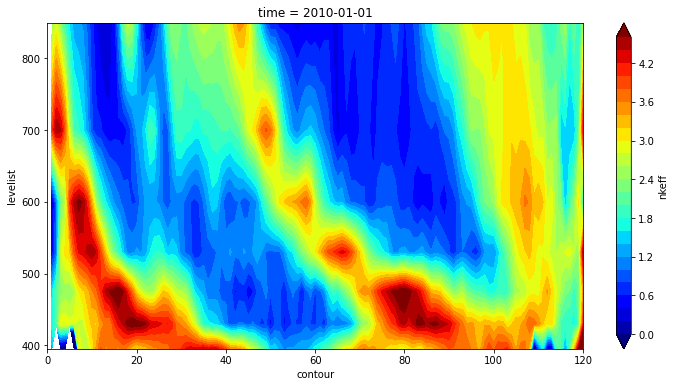

In [9]:
np.log(nkeff_xc[8:]).plot.contourf(figsize=(12, 6), cmap='jet', levels=np.linspace(0, 4.6, 24))

In [10]:
from GeoApps.ContourMethods import ContourAnalysisInLatLon
from GeoApps.DiagnosticMethods import Dynamics
from GeoApps.GridUtils import add_latlon_metrics

In [11]:
dset, grid = add_latlon_metrics(dset)
tracer = dset.pv
grdS = Dynamics(dset, grid).cal_squared_gradient(tracer)


In [12]:
# Construct an analysis class using PV as the tracer
analysis = ContourAnalysisInLatLon(dset, tracer, grid)


# This should be called first to initialize contours from minimum value
# to maximum value (within lat/lon dims) using `N` contours.
N   = 121
ctr = analysis.cal_contours(N, dims=['latitude', 'longitude'])#.metpy.dequantify()
ctr

<xarray.DataArray 'pv' (level: 15, contour: 121)>
array([[-4.34436952e-05, -4.15529328e-05, -3.96621704e-05, ...,
         1.79666269e-04,  1.81557031e-04,  1.83447793e-04],
       [-3.12895281e-05, -2.95687539e-05, -2.78479797e-05, ...,
         1.71761828e-04,  1.73482603e-04,  1.75203377e-04],
       [-1.68830156e-05, -1.58910649e-05, -1.48991141e-05, ...,
         1.00167172e-04,  1.01159123e-04,  1.02151073e-04],
       ...,
       [-8.51756777e-05, -8.26942073e-05, -8.02127370e-05, ...,
         2.07637823e-04,  2.10119294e-04,  2.12600764e-04],
       [-1.42589153e-04, -1.37360960e-04, -1.32132767e-04, ...,
         4.74337621e-04,  4.79565814e-04,  4.84794007e-04],
       [-3.23796354e-04, -3.09809882e-04, -2.95823411e-04, ...,
         1.32660728e-03,  1.34059375e-03,  1.35458022e-03]])
Coordinates:
  * level    (level) int32 265 275 285 300 315 330 ... 430 475 530 600 700 850
    time     datetime64[ns] 2010-01-01
  * contour  (contour) float64 0.0 1.0 2.0 3.0 4.0 ... 117.0 118.0 119.0 120.0

In [13]:
# Calculate various diagnostics defined in contour-based coordinates
area    = analysis.cal_integral_within_contours(ctr, out_name='intArea')
intgrdS = analysis.cal_integral_within_contours(ctr, grdS, out_name='intgrdS')
latEq   = analysis.cal_equivalent_coords(area)
dgrdSdA = analysis.cal_gradient_wrt_area(intgrdS, area)
dqdA    = analysis.cal_gradient_wrt_area(ctr, area)
Leq2    = analysis.cal_sqared_equivalent_length(dgrdSdA, dqdA)
Lmin    = analysis.cal_minimum_possible_length(latEq)
nkeff   = analysis.cal_normalized_Keff(Leq2, Lmin)

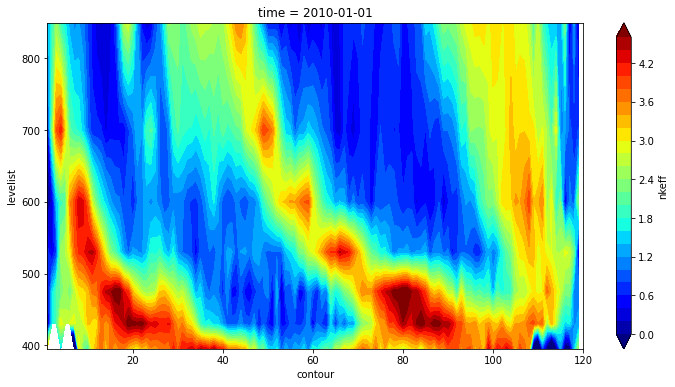

In [14]:
np.log(nkeff[8:]).plot.contourf(figsize=(12, 6), cmap='jet', levels=np.linspace(0, 4.6, 24))

# Differences

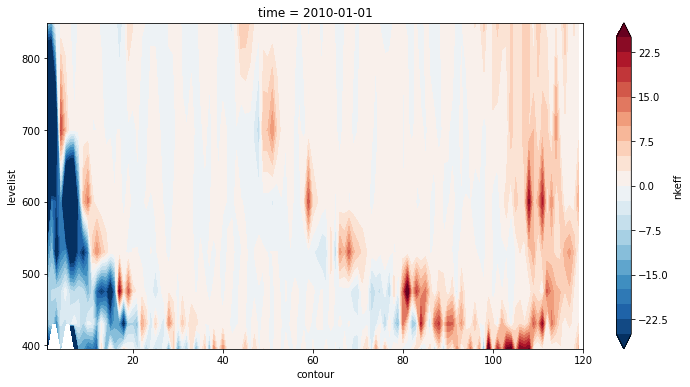

In [47]:
(nkeff[8:]-nkeff_xc[8:]).plot.contourf(
    figsize=(12, 6), 
    cmap='RdBu_r', 
    robust = True,
    levels = 21
)

Text(0.5, 1.0, 'GeoApps-xcontour')

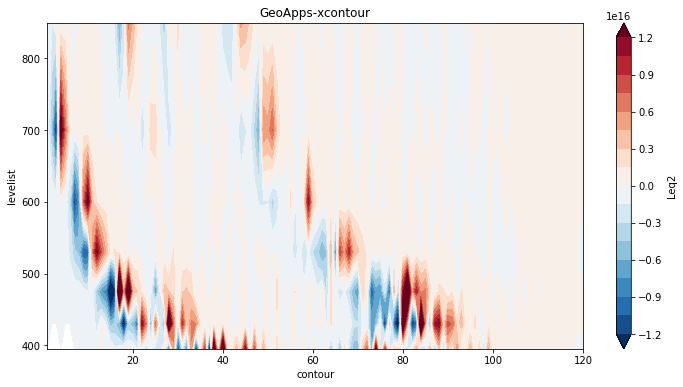

In [48]:
(Leq2[8:]-Leq2_xc[8:]).plot.contourf(
    figsize=(12, 6), 
    cmap='RdBu_r', 
    robust = True,
    levels = 21
)
plt.title('GeoApps-xcontour')

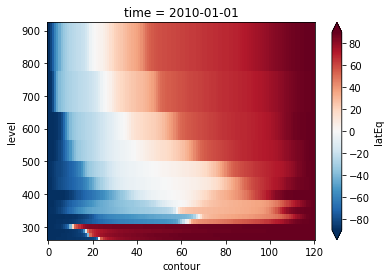

In [29]:
latEq.plot(robust = True)

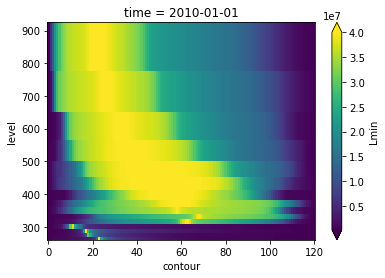

In [32]:
Lmin.plot(robust = True)

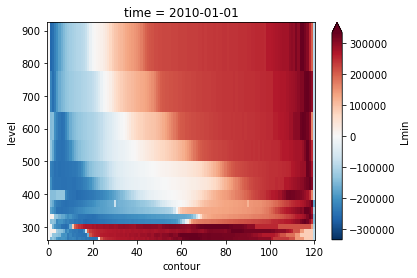

In [34]:
(Lmin-Lmin_xc).plot(robust = True)

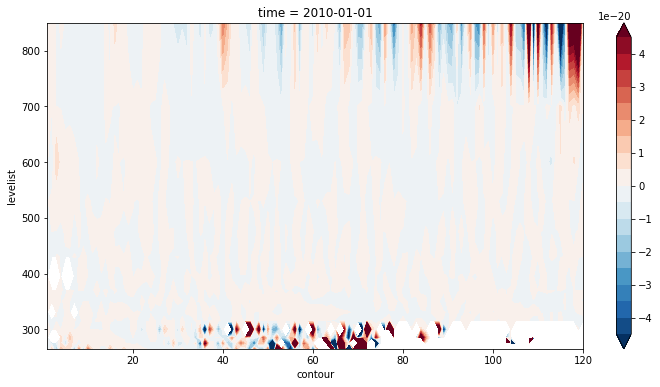

In [44]:
(dgrdSdA-dintSdA_xc).plot.contourf(
    figsize=(12, 6), 
    cmap='RdBu_r', 
    robust = True,
    levels = 21
)